# 匯入套件&資料集

In [1]:
from keras.preprocessing.image import img_to_array#圖片轉爲array
from keras.utils import np_utils #相當於one-hot
from tensorflow.keras.utils import to_categorical
from imutils import paths
from tqdm import tqdm
import cv2
import pandas as pd 
import numpy as np
import random
import os

import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalMaxPooling2D
from keras.layers import MaxPooling2D
from keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import categorical_crossentropy

from __future__ import print_function
import keras
from keras import models 
from keras import layers
from keras import backend as K
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.pyplot as mp

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
def load_data(path,norm_size,class_num):
    print("Loading {}".format(path))
    data = []#圖片數據x
    label = []#圖片標籤y
    image_paths = sorted(list(paths.list_images(path))) #讀取所有文件路徑
    random.seed(0)#保證每次數據順序一致
    random.shuffle(image_paths)#將所有的文件路徑打亂    
    for each_path in tqdm(image_paths):
        image = cv2.imread(each_path)#讀取文件
        image = cv2.resize(image,(norm_size,norm_size))#統一圖片尺寸
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        data.append(image)
        maker = each_path.split(os.path.sep)[-2] #sep切分文件目錄，標籤類別爲文件夾名稱的變化       
        if maker == 'Tai-Nong No.81':
            label.append(0)
        elif maker == 'Tai-Nong No.82':
            label.append(1)
        else:
            label.append(2)
    data = np.array(data,dtype="float32")
    label = np.array(label,dtype="int32")
    return data,label

In [4]:
class_num = 3 #類別 (共三類)
norm_size = 128 #圖片長寬

#隨機生成訓練、驗證、測試集

Rice_train_images, Rice_train_labels = load_data("New_Rice_Dataset/train", norm_size, class_num)
Rice_validation_images, Rice_validation_labels = load_data("New_Rice_Dataset/validation", norm_size, class_num)
Rice_test_images, Rice_test_labels = load_data("New_Rice_Dataset/test", norm_size, class_num)

Loading New_Rice_Dataset/train


100%|██████████| 1200/1200 [03:55<00:00,  5.10it/s]


Loading New_Rice_Dataset/validation


100%|██████████| 150/150 [00:29<00:00,  5.12it/s]


Loading New_Rice_Dataset/test


100%|██████████| 150/150 [00:29<00:00,  5.16it/s]


In [5]:
print("shape of Rice_train = ",Rice_train_images.shape)
print("shape of Rice_validation = ",Rice_validation_images.shape)
print("shape of Rice_test = ",Rice_test_images.shape)

shape of Rice_train =  (1200, 128, 128, 3)
shape of Rice_validation =  (150, 128, 128, 3)
shape of Rice_test =  (150, 128, 128, 3)


In [6]:
# 顯示圖片
def plot_img(n):    
    #繪圖
    plt.imshow(n.astype('uint8'), cmap='binary')   
    plt.show()

In [7]:
print(Rice_train_labels[270])

0


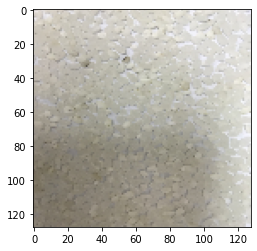

In [8]:
plot_img(Rice_train_images[4])

# 正規化&One-Hot

In [9]:
x_train = Rice_train_images.astype('float32')/255
x_validation = Rice_validation_images.astype('float32')/255
x_test = Rice_test_images.astype('float32')/255

#one-hot
y_train = np_utils.to_categorical(Rice_train_labels)
y_validation = np_utils.to_categorical(Rice_validation_labels)
y_test = np_utils.to_categorical(Rice_test_labels)

# 模型建模

In [10]:
K.clear_session()

model = Sequential()
model.add(Conv2D(filters=3, kernel_size=3, strides=1, input_shape=(128, 128, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(16,activation='relu')) 
model.add(BatchNormalization()) 
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',f1_m,precision_m, recall_m])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 3)       84        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

# 訓練&輸出

In [11]:
train_history=model.fit(x_train, y_train, validation_data=(x_validation,y_validation), epochs=10, batch_size=32,  validation_steps=3)

Epoch 1/10
38/38 [==============================] - 44s 1s/step - loss: 1.0677 - accuracy: 0.4192 - f1_m: 0.2249 - precision_m: 0.5022 - recall_m: 0.1497 - val_loss: 1.1119 - val_accuracy: 0.3542 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 42s 1s/step - loss: 0.9437 - accuracy: 0.5067 - f1_m: 0.3661 - precision_m: 0.6291 - recall_m: 0.2615 - val_loss: 1.0863 - val_accuracy: 0.3542 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 42s 1s/step - loss: 0.7878 - accuracy: 0.6583 - f1_m: 0.5766 - precision_m: 0.7589 - recall_m: 0.4696 - val_loss: 1.7950 - val_accuracy: 0.3438 - val_f1_m: 0.3437 - val_precision_m: 0.3438 - val_recall_m: 0.3438
Epoch 4/10
38/38 [==============================] - 43s 1s/step - loss: 0.6560 - accuracy: 0.7417 - f1_m: 0.6907 - precision_m: 0.8150 - recall_m: 0.6020 - val_loss: 1.3013 - val_accur

In [12]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_train, y_train)
print('Train:')
print('Loss:', np.round(loss, 4))
print('Accuracy: ', np.round(accuracy, 4))
print('Precision: ', np.round(precision, 4))
print('Recall: ', np.round(recall, 4))
print('F1 score: ', np.round(f1_score, 4))

38/38 [==============================] - 10s 274ms/step - loss: 0.4524 - accuracy: 0.7642 - f1_m: 0.7642 - precision_m: 0.7980 - recall_m: 0.7336
Train:
Loss: 0.4524
Accuracy:  0.7642
Precision:  0.798
Recall:  0.7336
F1 score:  0.7642


In [13]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_validation, y_validation)
print('Validation:')
print('Loss:', np.round(loss, 4))
print('Accuracy: ', np.round(accuracy, 4))
print('Precision: ', np.round(precision, 4))
print('Recall: ', np.round(recall, 4))
print('F1 score: ', np.round(f1_score, 4))

5/5 [==============================] - 1s 256ms/step - loss: 1.1008 - accuracy: 0.5800 - f1_m: 0.5828 - precision_m: 0.5949 - recall_m: 0.5716
Validation:
Loss: 1.1008
Accuracy:  0.58
Precision:  0.5949
Recall:  0.5716
F1 score:  0.5828


In [16]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test)
print('Test:')
print('Loss:', np.round(loss, 4))
print('Accuracy: ', np.round(accuracy, 4))
print('Precision: ', np.round(precision, 4))
print('Recall: ', np.round(recall, 4))
print('F1 score: ', np.round(f1_score, 4))

5/5 [==============================] - 1s 255ms/step - loss: 0.5933 - accuracy: 0.7333 - f1_m: 0.7267 - precision_m: 0.7399 - recall_m: 0.7142
Test:
Loss: 0.5933
Accuracy:  0.7333
Precision:  0.7399
Recall:  0.7142
F1 score:  0.7267


# 繪製圖表

In [14]:
def show_train_history(train_history):    
    plt.plot(train_history.history["accuracy"])
    plt.plot(train_history.history["val_accuracy"])
    plt.title("Train History")
    plt.xticks(np.arange(10),np.arange(10).astype(str))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
    fig=plt.gcf()
    fig.set_size_inches(16, 14)
    plt.subplot(221)
    plt.plot(train_history.history["loss"])
    plt.plot(train_history.history["val_loss"])
    plt.title("Train History")
    plt.xticks(np.arange(10),np.arange(10).astype(str))    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "validation"], loc="upper left")
    
    plt.subplot(222)
    plt.plot(train_history.history["f1_m"])
    plt.plot(train_history.history["val_f1_m"])
    plt.title("Train History")
    plt.xticks(np.arange(10),np.arange(10).astype(str))    
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.legend(["train", "validation"], loc="upper left")
    
    plt.subplot(223)
    plt.plot(train_history.history["precision_m"])
    plt.plot(train_history.history["val_precision_m"])
    plt.title("Train History")
    plt.xticks(np.arange(10),np.arange(10).astype(str))    
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.legend(["train", "validation"], loc="upper left")
    
    plt.subplot(224)
    plt.plot(train_history.history["recall_m"])
    plt.plot(train_history.history["val_recall_m"])
    plt.title("Train History")
    plt.xticks(np.arange(10),np.arange(10).astype(str))    
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend(["train", "validation"], loc="upper left")
    
    plt.show()

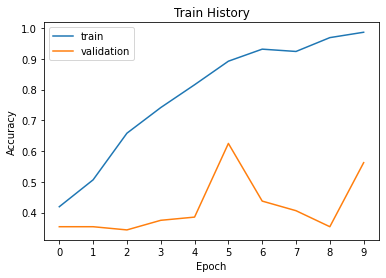

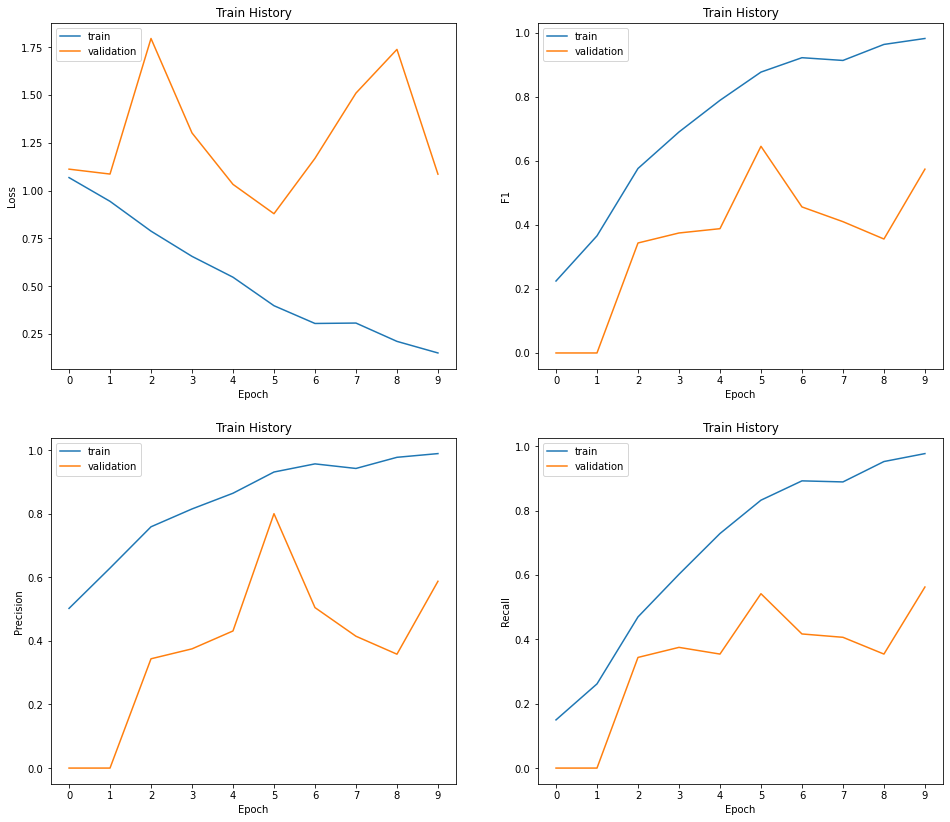

In [15]:
show_train_history(train_history) 